# Лабораторна робота 12, 13

У лабораторній роботі *Оцінка методів виявлення аномалій* ви повинні були навчитися:

1. Як застосувати метрики Precision@n, середня точність і оцінки ROC
2. Згенерувати дані виявлення аномалій із класифікаційних наборів даних для базової оцінки
3. Сканування параметрів без перехресної перевірки

In [1]:
from collections import namedtuple
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys

import sklearn.neighbors as neighbors
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Імпорт даних

Ми збираємося переглянути журнали датчиків із шатла з [репозиторію навчання UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29). Останній стовпець містить (ручну) класифікацію режиму роботи човника.

У даних немає міток для датчиків або рядка заголовка, тому ми вручну створимо імена заголовків від `attr_0` до `attr_8` для даних датчика та `class` для коду робочого режиму.

In [2]:
col_names = [f'attr_{n}' for n in range(9)] + ['class']
df = pd.read_csv('shuttle.tst', delim_whitespace=True, names=col_names)

C:\Users\sviat\AppData\Local\Temp\ipykernel_16316\324401846.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('shuttle.tst', delim_whitespace=True, names=col_names)


In [3]:
df.head()

,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,class
0,55,0,81,0,-6,11,25,88,64,4
1,56,0,96,0,52,-4,40,44,4,4
2,50,-1,89,-7,50,0,39,40,2,1
3,53,9,79,0,42,-2,25,37,12,4
4,55,2,82,0,54,-6,26,28,2,1


Ми будемо імітувати виявлення аномалій за допомогою
- створення 1 класу (~80%) точок
- видалення наступного за величиною класу (клас 4)
- поєднання всіх інших класів як аномалій

Перш ніж видалити стовпець класу, давайте подивимося на частоту кожного класу:

In [4]:
df['class'].value_counts()

class
1    11478
4     2155
5      809
3       39
2       13
6        4
7        2
Name: count, dtype: int64

Тепер замініть атрибут «клас» на атрибут «аномалія».

In [5]:
df = df[ df['class']!=4 ] #видалення класу 4
df['anomaly'] = (df['class'] != 1).astype(bool) #поєднання всіх інших класів як аномалій
df.drop('class', axis=1, inplace=True)
df.head()

,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,anomaly
2,50,-1,89,-7,50,0,39,40,2,False
4,55,2,82,0,54,-6,26,28,2,False
5,41,0,84,3,38,-4,43,45,2,False
6,37,0,100,0,36,-8,63,64,2,False
7,46,0,83,0,46,0,37,36,0,False


In [6]:
df.anomaly.value_counts(normalize=True)

anomaly
False    0.929769
True     0.070231
Name: proportion, dtype: float64

Ми маємо приблизно 7% даних як аномальні.

Давайте оцінимо продуктивність IsolationForest на цьому наборі даних (дивіться лекцію де обговорювався IsolationForest). Зауважте, що в ізольованому лісі немає нічого особливого (за винятком того, що ми можемо пропустити масштабування даних) — ми можемо використовувати будь-який із класифікаторів виявлення аномалій у тому самому наборі даних, якщо він реалізує метод `decision_function`.

# Створення нашого детектора аномалій

In [7]:
frac_anomalies = df['anomaly'].sum()/df['anomaly'].size

iso_forest = IsolationForest(contamination=frac_anomalies, random_state=42)
y_predict = iso_forest.fit_predict(df.drop('anomaly', axis=1))

In [8]:
df['anomaly'].sum()

np.int64(867)

In [9]:
df['anomaly'].size

12345

Зверніть увагу, що частка прогнозу для аномалії (`-1`) точно відповідає параметру `frac_anomalies`

In [10]:
msg = f"""
Fraction of anomalies predicted:                 {(y_predict == -1).sum() / y_predict.size}
Fraction of anomalies given to isolation forest: {frac_anomalies}
"""
print(msg)


Fraction of anomalies predicted:                 0.07023086269744835
Fraction of anomalies given to isolation forest: 0.07023086269744835



Ми можемо отримати доступ до необроблених результатів із `iso_forest.decision_function`

In [11]:
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

In [12]:
y_scores

array([ 0.14982987,  0.14135482,  0.19075111, ...,  0.19712148,
       -0.06096018,  0.06979992], shape=(12345,))

# Метрика: Precision@n

Sklearn не має вбудованої формули для precision@n, тому нам доведеться написати власну. Ми продемонструємо, що вони дублюють результати, які ми очікуємо на наборі даних точок.

Формула для P@n така
\begin{equation*}
P@n = \frac{\text{# аномалій у перших $n$ записів}}{n}
\end{equation*}
Давайте напишемо функцію для надання нам P@n:

In [13]:
def precision_at_n(y_is_anomaly_true, y_scores, n_max = 0):
    """
    y_scores: список оцінок  (нижче означає більшу ймовірність аномалії)
     y_is_anomaly_true: логічний список, y_is_anomaly_true[i] має значення True
     якщо i-та точка є аномалією

     Повертає масив оцінок для P@n для n у 1, 2, 3, ...., n_max.

     Якщо n_max задано як 0, ранжирується P@n для всього набору даних
    """
    if not n_max:
        n_max = len(y_scores)

    is_anomaly_sorted_by_score = [is_anomaly for _,
                                  is_anomaly in sorted(zip(y_scores, y_is_anomaly_true))]
    return [sum(is_anomaly_sorted_by_score[:n])/n for n in range(1, n_max+1)]

Ми можемо перевірити це на прикладі 4 рядків, який ми навели в лекції, де рядки 1 і 3 були аномаліями

In [14]:
y_scores = np.array([-0.03598, -0.033510, -0.005384, 0.000330])
y_true = np.array([1, 0, 1, 0])
# продемонструйте це на прикладі, наведеному в лекції, де рядки 1 і 3 були аномальними
precision_at_n(y_true, y_scores)

[np.float64(1.0),
 np.float64(0.5),
 np.float64(0.6666666666666666),
 np.float64(0.5)]

average_precision (Середня точність): Візьміть середнє P@k для k = 1,2,…n, де k-та точка є аномалією (значення k, що відповідають нормальним точкам, ігноруються)

In [15]:
def custom_average_precision(y_is_anomaly_true, y_scores):
    sorted_scores_and_truth = np.array([(score, is_anomaly)
                                        for score, is_anomaly in
                                        sorted(zip(y_scores, y_is_anomaly_true))])
    scores, is_anomaly = sorted_scores_and_truth[:, 0], sorted_scores_and_truth[:, 1]
    p_at_n = np.array(precision_at_n(is_anomaly, y_scores))
    return (is_anomaly * p_at_n).sum() / is_anomaly.sum()

In [16]:
# Застосуйте це до версії, поданої на слайдах
custom_average_precision(y_true, y_scores)

np.float64(0.8333333333333333)

**УВАГА:**

Sklearn також надає дуже схожий на вигляд `average_precision_score` у `sklearn.metrics`. Документація для функції надається [тут](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html).

Використання цієї функції є трохи дивним, тому що вона в основному використовується для проблем класифікації (де оцінка - інтерпретується як _вища_ оцінка означає _більшу_ ймовірність позитивного класу). Більшість наших вихідних даних `decision_functions` мають аномалії за замовчуванням до класу `-1`, а _lower_ (тобто більш негативну оцінку) означає, що точка _більш вірогідно буде аномалією.

Є два виправлення:
* якщо `y_score` є `np.array`, ми можемо передати `-y_score`, щоб упорядкувати так, як очікує *sklearn*.
* ми можемо встановити `pos_label` на 0 (це легко зробити за допомогою ключового аргументу).

In [17]:
print(f"""
Setting the pos_label to class 0: {average_precision_score(y_true, y_scores, pos_label=0)}
Using the negative score:         {average_precision_score(y_true, -y_scores)}""")


Setting the pos_label to class 0: 0.8333333333333333
Using the negative score:         0.8333333333333333


## Precision@n для набору даних шатла

Давайте подивимося, як P@n і Average Precision виглядають на наборі даних шатла.

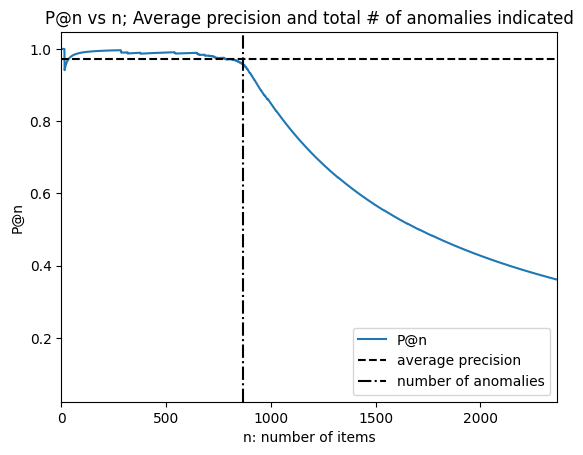

In [18]:
# скинути оцінки до тих, які створює наша модель
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
average_precision = average_precision_score(df['anomaly'], -y_scores)
plt.figure(dpi=100)

plt.plot(precision_at_n(df['anomaly'], y_scores), label='P@n')
plt.axhline(average_precision, linestyle='--', color='k',
            label='average precision')
plt.axvline(num_anomalies, linestyle='-.', color='k', label='number of anomalies')
plt.xlim(0, num_anomalies + 1500)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n; Average precision and total # of anomalies indicated');

In [19]:
print(f"Значення середньої точності становить {average_precision:6.4f}")

Значення середньої точності становить 0.9725


Ми бачимо, що P@n досить сильно залежить від кількості елементів $n$ для малих n ($n \ll 50$), але потім залишається відносно постійним до $n\sim 869$, кількості аномалій у даних. Після цього розміщення більшої кількості елементів із ранжованого списку просто зменшує середню точність як степеневий закон $1/n$.

Середня точність усереднюється лише в місці розташування аномалій (тобто на початку набору даних), тому вона набагато вища за середнє значення P@n.

Давайте зосередимо нашу увагу на падінні *Average precision* на початку, коли $n$ мале.

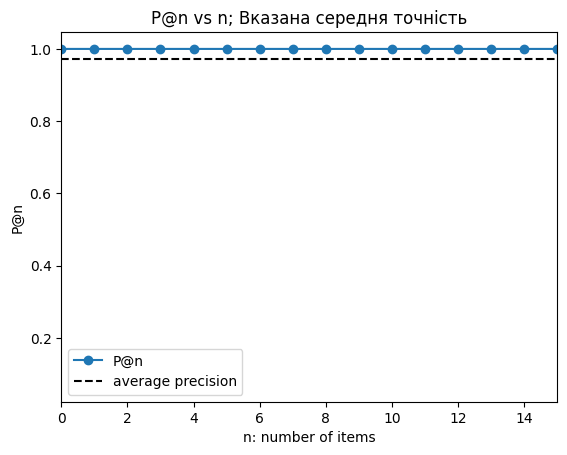

In [20]:
# скинути оцінки до тих, які створює наша модель
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
average_precision = average_precision_score(df['anomaly'], -y_scores)
plt.figure(dpi=100)

plt.plot(precision_at_n(df['anomaly'], y_scores), label='P@n', marker='o')
plt.axhline(average_precision, linestyle='--', color='k',
            label='average precision')
plt.xlim(0, 15)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n; Вказана середня точність');

При низьких значеннях $n$ P@n може бути дуже шумним.

### Adjusted  P@n (скориговане P@n) і Adjusted Average Precision (скоригована середня точність)

Ці оцінки також не надаються  в *sklearn*, але маніпуляції для отримання скоригованого P@n із необробленого P@n прості:

In [21]:
# скинути оцінки до тих, які створює наша модель
y_scores = iso_forest.decision_function(df.drop('anomaly', axis=1))

num_anomalies = sum(df['anomaly'])
num_points = df['anomaly'].size
frac_anomalies = num_anomalies / num_points

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

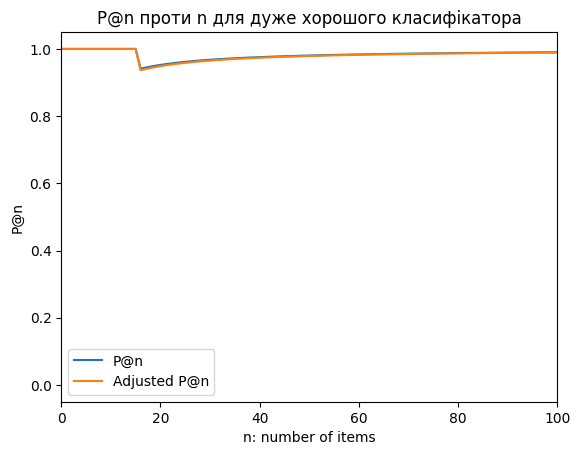

In [22]:
plt.figure(dpi=100)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.xlim(0, 100)
plt.legend()
plt.title('P@n проти n для дуже хорошого класифікатора');

Цей класифікатор так добре виконує свою роботу, що ми наближаємося до оптимальної продуктивності. Ми можемо навчити гіршу версію ізольованого лісу для порівняння:

In [23]:
bad_iso_forest = IsolationForest(n_estimators = 3, contamination=frac_anomalies, random_state=42)
bad_iso_forest.fit(df.drop('anomaly', axis=1))
bad_y_scores = bad_iso_forest.decision_function(df.drop('anomaly', axis=1))

p_at_n = np.array(precision_at_n(df['anomaly'], bad_y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -bad_y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

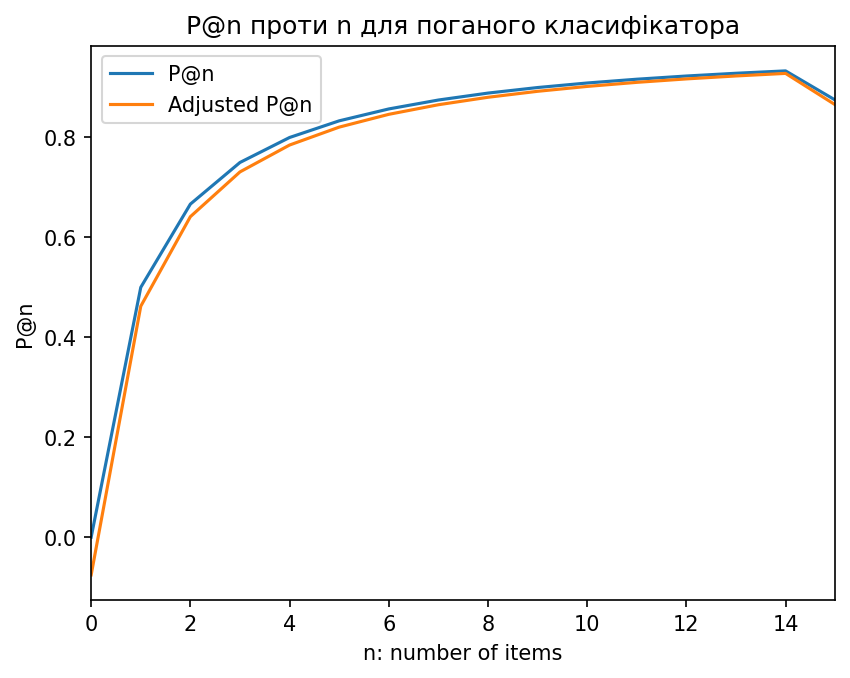

In [24]:
plt.figure(dpi=150)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.xlim(0, 15)
plt.legend()
plt.title('P@n проти n для поганого класифікатора');

Оскільки n невелике, ми бачимо ефект застосування «коригування» (тобто, наскільки добре працює класифікатор порівняно з випадковим ранжируванням).

## Ті самі дані, інший алгоритм

Давайте використаємо деякі алгоритми на основі відстані, які ми бачили раніше у відповідній лекції. Щоб зробити _хороші_ методи виявлення аномалій, ми повинні застосувати
- масштабування ознак
- можливо застосувати PCA для зменшення розмірів.

Ми використаємо наївний підхід і оцінимо результати за допомогою P@n і середньої точності. Потім ми знову обробимо дані за допомогою відповідних етапів попередньої обробки та побачимо, як покращаться результати.

In [25]:
# з лекції , де ми використовуємо середню відстань точки до її n_сусідів, щоб оцінити її
def do_nn_avg_outlier_scores(obs, n_neighbors=1):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists.mean(axis=1)
    return scores

In [26]:
features = df.drop('anomaly', axis=1)

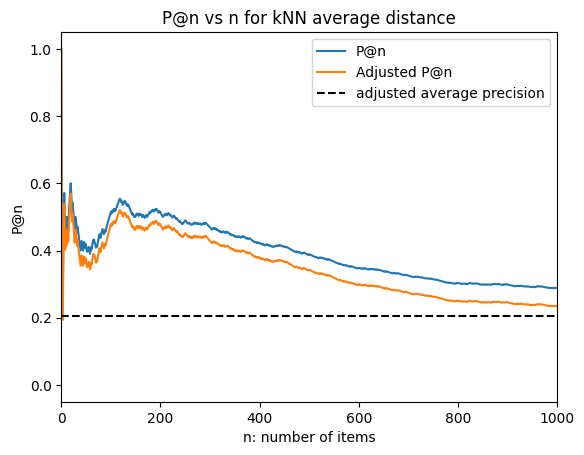

In [27]:
# ми хочемо, щоб менші числа (тобто більші від’ємні відстані) з більшою ймовірністю були викидами
y_scores = -do_nn_avg_outlier_scores(features, n_neighbors=20)

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

plt.figure(dpi=100)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')

plt.axhline(adj_ave_precision, linestyle='--', color='k',
            label='adjusted average precision')
plt.xlim(0, 1000)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n vs n for kNN average distance');

In [28]:
# пошук найкращого значення n (може зайняти деякий час)
ap = [(average_precision_score(df['anomaly'], do_nn_avg_outlier_scores(features, n_neighbors=n)), n)
      for n in range(2, 100)]

In [29]:
sorted(ap, reverse=True)[:5]

[(np.float64(0.32199126982182036), 99),
 (np.float64(0.3216555179365431), 98),
 (np.float64(0.3212325567133122), 97),
 (np.float64(0.32084458473248517), 96),
 (np.float64(0.32045332300104606), 95)]

Здається, ми отримуємо найкращі результати для середньої точності з 99 сусідами!

# Знову використовуючи kNN, але з масштабуванням і зменшенням розмірів

Як обговорювалося в лекції 4, ми повинні виконувати стандартне масштабування, коли використовуємо методи на основі відстані. Наведений вище метод kNN демонструє _поганий_ детектор аномалій. Ми можемо побачити, як наші показники можуть виміряти різницю між kNN, виконаним належним чином (з масштабуванням і зменшенням розмірів), порівняно з простим методом.

In [30]:
ssX = StandardScaler()
features_scaled = ssX.fit_transform(features.astype(float))

# Скільки функцій нам потрібно?
pca = PCA()
pca.fit(features_scaled)
np.cumsum(pca.explained_variance_ratio_)# expanded_variance_ratio_ вказує частку дисперсії набору даних, яку враховує кожен головний компонент.

array([0.32991315, 0.52650241, 0.67768337, 0.81931787, 0.92839029,
       0.99980226, 0.9998828 , 0.99995741, 1.        ])

Схоже, що перші 6 компонентів охоплюють 99,9% дисперсії, тому ми відповідно зменшимо розмірність наших даних.

In [31]:
pca = PCA(n_components=6)
pca_features = pca.fit_transform(features_scaled)

Тепер давайте спробуємо різні значення $k$, щоб побачити, скільки сусідів нам слід використовувати. Ми відстежуватимемо середню оцінку точності та значення $k$, яке дало нам цю оцінку:

In [32]:
# Попередження: цей код виконується приблизно за 90 секунд!
ap = [(average_precision_score(df['anomaly'], do_nn_avg_outlier_scores(pca_features, n_neighbors=n)), n)
      for n in range(100, 200)]

In [33]:
# Тепер подивіться на середню оцінку точності для різних кількостей найближчих сусідів
sorted(ap, reverse=True)[:5]

[(np.float64(0.30670148164768646), 199),
 (np.float64(0.3058883460537052), 198),
 (np.float64(0.3051231212974257), 197),
 (np.float64(0.304370363793823), 196),
 (np.float64(0.3036199874348088), 195)]

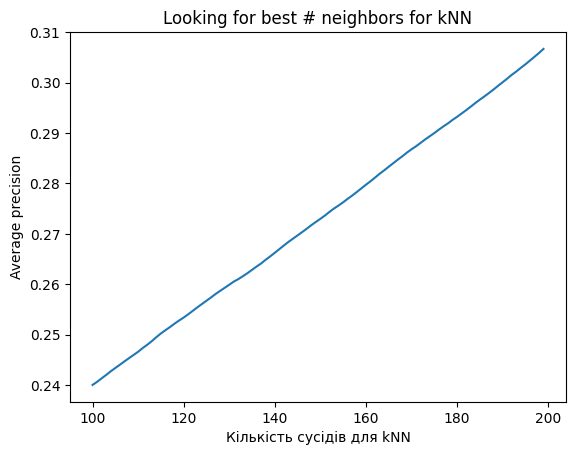

In [34]:
plt.figure(dpi=100)
plt.plot(np.array(ap)[:,1], np.array(ap)[:, 0])
plt.title('Looking for best # neighbors for kNN')
plt.ylabel('Average precision')
plt.xlabel('Кількість сусідів для kNN');

Оцінка постійно зростає зі збільшенням кількості сусідів (тобто ми повинні постійно збільшувати кількість сусідів понад 200). Деякі експерименти показують, що `n_neighbors` $\approx 600$ максимізує середню точність.

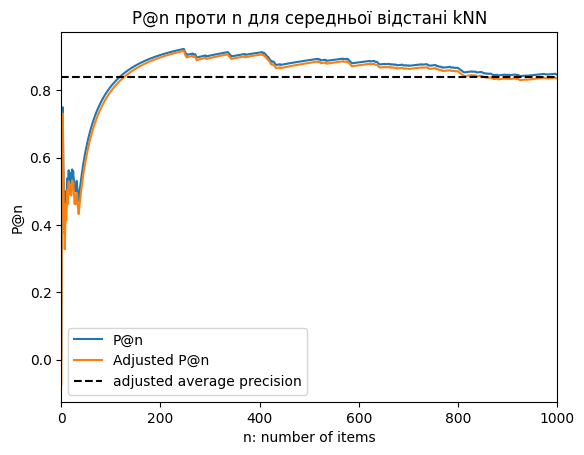

In [35]:
y_scores = -do_nn_avg_outlier_scores(pca_features, n_neighbors=600)

p_at_n = np.array(precision_at_n(df['anomaly'], y_scores))
adj_p_at_n = (p_at_n - frac_anomalies) / (1 - frac_anomalies)

ave_precision = average_precision_score(df['anomaly'], -y_scores)
adj_ave_precision = (ave_precision - frac_anomalies) / (1 - frac_anomalies)

plt.figure(dpi=100)

plt.plot(p_at_n, label='P@n')
plt.plot(adj_p_at_n, label='Adjusted P@n')

plt.axhline(adj_ave_precision, linestyle='--', color='k',
            label='adjusted average precision')
plt.xlim(0, 1000)
plt.xlabel('n: number of items')
plt.ylabel('P@n')
plt.legend()
plt.title('P@n проти n для середньої відстані kNN');

# Використання ROC

Одним із стандартних показників, який зазвичай використовується як для класифікації, так і для виявлення аномалій, є крива оператора приймача (крива ROC- Receiver Operating Characteristic). Крива показує компроміс між хибно-позитивними та хибно-негативними показниками, оскільки порогове значення оцінки змінюється.

Порогове значення можна вибрати як граничну оцінку (типовий для класифікації) або граничний ранг (типовий для проблем виявлення аномалій).

_Площа під кривою_ дає нам одне число, яке говорить нам, наскільки добре класифікатор розрізняє два випадки. Число можна інтерпретувати як ймовірність того, що навмання вибрана аномалія має вищу оцінку, ніж навмання вибрана норма.

\begin{equation*}
\text{AUC} = P(\text{показник випадкової аномалії} > \text{показник випадкової нормальної точки})
\end{equation*}

In [36]:
roc_model = namedtuple('roc_model', 'name model_scores')

Отримати показники ROC AUC для різних моделей просто:

In [37]:
roc_models = [
    roc_model('Isolation Forest', -iso_forest.decision_function(features)),
    roc_model('kNN no proprocessing', do_nn_avg_outlier_scores(features, n_neighbors=20)),
    roc_model('kNN processing', do_nn_avg_outlier_scores(pca_features, n_neighbors=600))
]

for model in roc_models:
    label = f"{model.name} ({roc_auc_score(df['anomaly'], model.model_scores):6.4f})"
    print(label)

Isolation Forest (0.9957)
kNN no proprocessing (0.8002)
kNN processing (0.9918)


Ми також можемо зробити графік із усіма трьома кривими ROC на ньому:

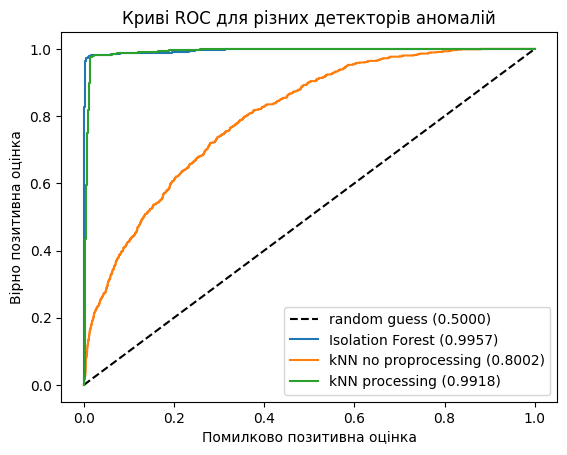

In [38]:
plt.figure(dpi=100)

plt.plot([0,1], [0,1], 'k--', label='random guess (0.5000)')

for model in roc_models:
    label = f"{model.name} ({roc_auc_score(df['anomaly'], model.model_scores):6.4f})"
    fpr, tpr, _ = roc_curve(df['anomaly'], model.model_scores)
    plt.plot(fpr, tpr, label=label)

plt.xlabel("Помилково позитивна оцінка")
plt.ylabel("Вірно позитивна оцінка")
plt.title("Криві ROC для різних детекторів аномалій")
plt.legend();

# Остаточні коментарі

* Python має вбудований спосіб створення кривих ROC. 
* Багато наборів даних, у яких ви хочете виявити аномалії, не мають міток аномалій. Ви можете обробляти свої метрики в задачах класифікації з подібним розподілом даних, хоча вам може знадобитися зменшити вибірку мажортарних класів.

#### Вправа №1

Ми не перевіряємо результати під час встановлення гіперпараметрів для виявлення аномалії. Замість цього ми встановлюємо «розумний діапазон» гіперпараметрів (зазвичай визначається досвідом або експертом у предметній галузі), а потім розглядаємо наші метрики як середнє значення за всіма параметрами.

Використайте значення $k$ від $k=500$ до $k=600$ для обробленої моделі kNN.
* Яке середнє значення середньої точності (тобто візьміть середнє значення для 100 моделей з k в діапазоні від 500 до 600)
* Яка стандартна помилка середньої точності (тобто знайдіть стандартну помилку для тих самих 100 моделей).

Нагадування: стандартна помилка
$$\text{std err} = \frac{\sigma}{\sqrt{N}}$$
де $\sigma$ — стандартне відхилення, а $N$ — кількість моделей, за якими ви усереднюєте

#### Розв'язок №1

In [39]:
# Налаштування:
k_min = 500
k_max = 600

# Функція для обчислення outlier scores через середню відстань до k найближчих сусідів
def do_nn_avg_outlier_scores(obs, n_neighbors=1):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, _ = nn.kneighbors()
    scores = dists.mean(axis=1)
    return scores

aps = []

for k in range(k_min, k_max + 1):
    y_scores = -do_nn_avg_outlier_scores(pca_features, n_neighbors=k)  # мінус, бо менші відстані = більша ймовірність аномалії
    ap = average_precision_score(df['anomaly'], -y_scores)
    aps.append((ap, k))

# Обчислення середнього значення середньої точності і стандартної помилки
ap_values = [ap for ap, _ in aps]

print(sorted(aps, reverse=True)[:5])  # Топ-5 моделей

[(np.float64(0.8506817930135987), 600), (np.float64(0.8501055619897462), 599), (np.float64(0.8496371395584993), 598), (np.float64(0.8491586913956709), 597), (np.float64(0.848644328314531), 596)]


In [40]:
print(f"середнє значення середньої точності {np.mean(ap_values)}")

середнє значення середньої точності 0.8322481257862836


In [41]:
std_ap = np.std(ap_values, ddof=1)  # Зміщена дисперсія (sample std)
stderr_ap = std_ap / np.sqrt(len(ap_values))

print(f"стандартна помилка середньої точності {stderr_ap}")

стандартна помилка середньої точності 0.0010558892863353603


#### Вправа №2

Створіть детектор аномалії LOF на (масштабованому) наборі даних шатла, `pca_features` і `n_neighbors=2000`. Яка площа під кривою ROC? Візьміть кількість сусідів у діапазоні від 2000 до 3500 з кроком 100 і вкажіть середнє значення та стандартну помилку.

**Ресурси:** ми обговорювали моделі LOF в темі 5, або ви можете знайти документацію тут(https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) .

#### Рішення №2

In [42]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=2000, novelty=True)  # novelty=True для використання predict/decision_function
lof.fit(pca_features)
y_scores_lof = -lof.decision_function(pca_features)  # беремо мінус, бо LOF: чим менше score, тим більш "аномально"

roc_auc = roc_auc_score(df['anomaly'], y_scores_lof)
print(f"ROC_auc for lof processing {roc_auc}")

ROC_auc for lof processing 0.9910387717298005


In [43]:
from sklearn.metrics import average_precision_score
import numpy as np

# Перевіряєм різні n_neighbors від 2000 до 3400
aps = []
for n in range(2000, 3500, 100):
    lof = LocalOutlierFactor(n_neighbors=n, novelty=True)
    lof.fit(pca_features)
    scores = -lof.decision_function(pca_features)
    ap = average_precision_score(df['anomaly'], scores)
    aps.append((ap, n))

# Сортуємо за середньою точністю
aps_sorted = sorted(aps, reverse=True)[:5]
print(aps_sorted)

[(np.float64(0.9064823402904048), 3400), (np.float64(0.9058941134480544), 3300), (np.float64(0.9052451703639574), 3200), (np.float64(0.904589830295647), 3100), (np.float64(0.9038110321611277), 3000)]


In [44]:
ap_values = [ap for ap, _ in aps]

print(f"Середнє значення середньої точності {np.mean(ap_values)}")

Середнє значення середньої точності 0.8971974342068464


In [45]:
print(f"стандартна помилка середньої точностіє {np.std(ap_values, ddof=1) / np.sqrt(len(ap_values))}")

стандартна помилка середньої точностіє 0.0024336449314716195


#### Вправа №3

Ми дали інтерпретацію оцінки ROC як
> Ймовірність того, що навмання вибрана «нормальна» точка має вищу оцінку, ніж навмання вибрана «аномалія».

Давайте перевіримо це твердження. Нижче наведено набір оцінок для нормальних точок і набір оцінок для аномалій. Розрахуйте криві ROC двома методами:
1. Використання методу `roc_auc_score` sklearn. Вам потрібно буде якось приєднати оцінки.
2. Випадково намалюйте нормальну точку та аномалію і порівняйте результати. Повторіть це 10000 разів. Виведіть частку випадків, коли аномалія мала вищу оцінку.

In [46]:
np.random.seed(42)
normal_scores = np.random.normal(loc=700, scale=50,size=2000)
anomaly_scores = np.random.normal(loc=800, scale=20,size=80)

#### Рішення №3

In [47]:
# Об'єднуємо оцінки і формуємо мітки
y_scores = np.concatenate([normal_scores, anomaly_scores])
y_true = np.concatenate([np.zeros_like(normal_scores), np.ones_like(anomaly_scores)])

In [48]:
roc_auc = roc_auc_score(y_true, y_scores)
print(f"ROC AUC Score: {roc_auc:.8f}")

ROC AUC Score: 0.96325625


In [49]:
n_trials = 10000
wins = 0

for _ in range(n_trials):
    normal_sample = np.random.choice(normal_scores)
    anomaly_sample = np.random.choice(anomaly_scores)
    if anomaly_sample > normal_sample:
        wins += 1

fraction = wins / n_trials
print(f"частка випадків, коли аномалія мала вищу оцінку {fraction:.4f}")

частка випадків, коли аномалія мала вищу оцінку 0.9624
